In [1]:
data_dir = "../data/"
VOC2012_path = data_dir + "VOCdevkit/"
tracker_path = "../Tracking_SSD_ReID/"
ssd_weights_path = data_dir + "ssd_weights_epoch_0380.h5"
checkpoint_filepath = data_dir + "weights_vgg16styletransfer/"
final_model_path = data_dir + "weights_vgg16styletransfer_final/"

In [2]:
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import imageio
from tqdm import tqdm
import cv2

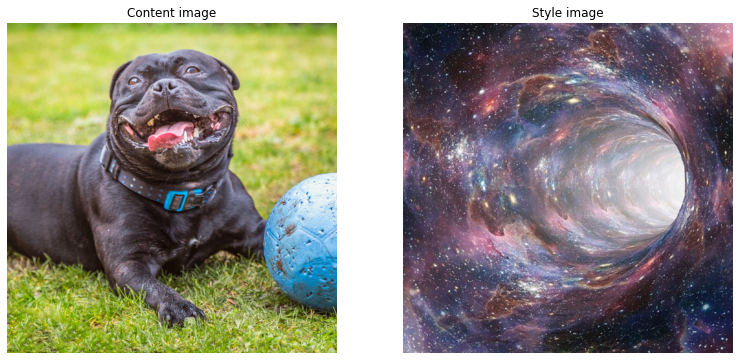

In [3]:
content_image = Image.open("imgs/content.jpg")
content_image_np = np.array(content_image)

style_image = Image.open("imgs/style.jpg")
style_image_np = np.array(style_image)

fig, axs = plt.subplots(1, 2, figsize=(13, 25), facecolor='w', edgecolor='k')

axs[0].axis('off')
axs[0].set_title("Content image")
axs[0].imshow(content_image_np)

axs[1].axis('off')
axs[1].set_title("Style image")
axs[1].imshow(style_image_np)

content_image = cv2.resize(content_image_np, (300, 300),
                           interpolation=cv2.INTER_NEAREST)
content_image = tf.expand_dims(tf.convert_to_tensor(content_image, dtype=tf.float32), 0)

style_image = cv2.resize(style_image_np, (300, 300),
                           interpolation=cv2.INTER_NEAREST)
style_image = tf.expand_dims(tf.convert_to_tensor(style_image, dtype=tf.float32), 0)

In [4]:
from models.VGG16StyleTransfer import VGG16StyleTransfer
inception = VGG16StyleTransfer(
    tracker_ssd_path = tracker_path, 
    ssd_weights_path = ssd_weights_path)

outputs = inception(tf.zeros([32, 300, 300, 3]))
for output in outputs:
    print(output.shape)

(32, 300, 300, 64)
(32, 300, 300, 64)
(32, 150, 150, 64)
(32, 150, 150, 128)
(32, 150, 150, 128)
(32, 75, 75, 128)
(32, 19, 19, 512)


In [5]:
def get_features(data):
    #data = preprocess_image(data)
    outputs = inception(data/255)
    
    def gram_calc(data):
        return tf.linalg.einsum('bijc,bijd->bcd', data, data) /\
            tf.cast(data.shape[1] * data.shape[2], tf.float32)     
    style_features = [gram_calc(layer) for layer in outputs[:-1]]
    return style_features, outputs[-1]

In [6]:
def get_loss(style_target, style_feature, content_target, content_feature):

    style_loss = tf.add_n([
        tf.reduce_mean(tf.square(features - targets))
        for features, targets in zip(style_feature, style_target)])
    content_loss = tf.add_n([
        0.5 * tf.reduce_sum(tf.square(features - targets))
        for features, targets in zip(style_feature, style_target)])

    return style_loss + 0.001 * content_loss

In [7]:
def training(style_image, content_image, optimizer, epochs=1):
    images = []

    style_targets, _ = get_features(style_image)
    _, content_targets = get_features(content_image)

    generated_image = tf.cast(content_image, dtype=tf.float32)
    generated_image = tf.Variable(generated_image) 

    images.append(tf.keras.preprocessing.image.array_to_img(tf.squeeze(content_image)))
    for n in tqdm(range(epochs)):
        with tf.GradientTape() as tape:
            style_features, content_features = get_features(generated_image)
            loss = get_loss(style_targets, style_features, content_targets, content_features)

        gradients = tape.gradient(loss, generated_image)
        optimizer.apply_gradients([(gradients, generated_image)])
        generated_image.assign(
          tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=255.0))

        tmp_img = tf.Variable(generated_image)
        images.append(tf.keras.preprocessing.image.array_to_img(tf.squeeze(tmp_img)))
    return images

In [8]:
adam = tf.keras.optimizers.Adam(learning_rate=10)

images = training(style_image, content_image, adam, epochs=50)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.50it/s]


In [9]:
out_gif = "imgs/training.gif"
images[0].save(out_gif, format='GIF',
               append_images=images[1:],
               save_all=True, loop=0)
gif = imageio.mimread(out_gif)
imageio.mimsave(out_gif, gif, fps=2)

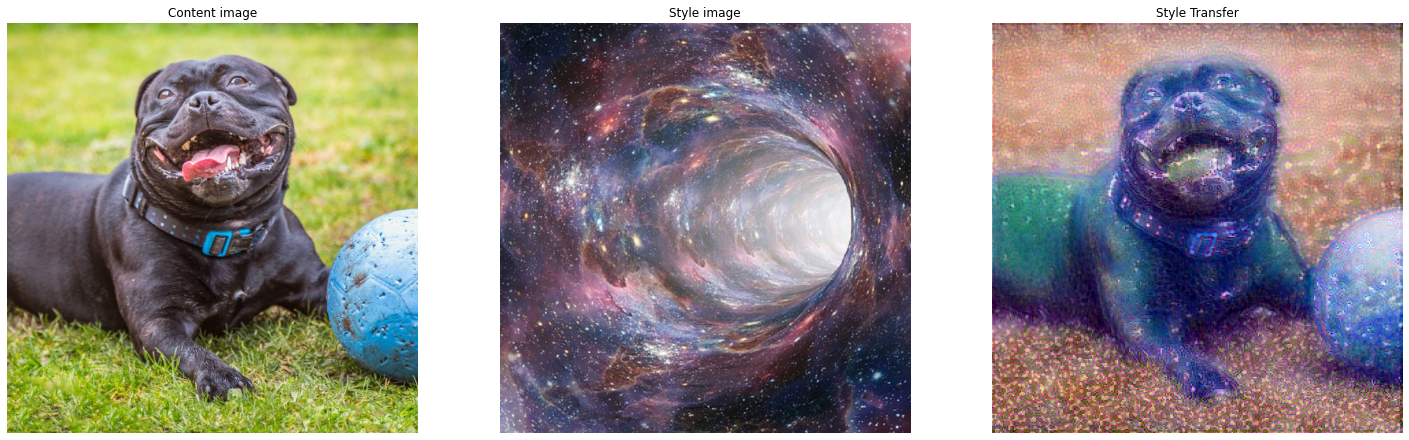

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(25, 40), facecolor='w', edgecolor='k')

axs[0].axis('off')
axs[0].set_title("Content image")
axs[0].imshow(content_image_np)

axs[1].axis('off')
axs[1].set_title("Style image")
axs[1].imshow(style_image_np)

axs[2].axis('off')
axs[2].set_title("Style Transfer")
axs[2].imshow(images[20])

In [17]:
fig.savefig('imgs/style_transfer.png', dpi=100, bbox_inches = 'tight', pad_inches = 1)